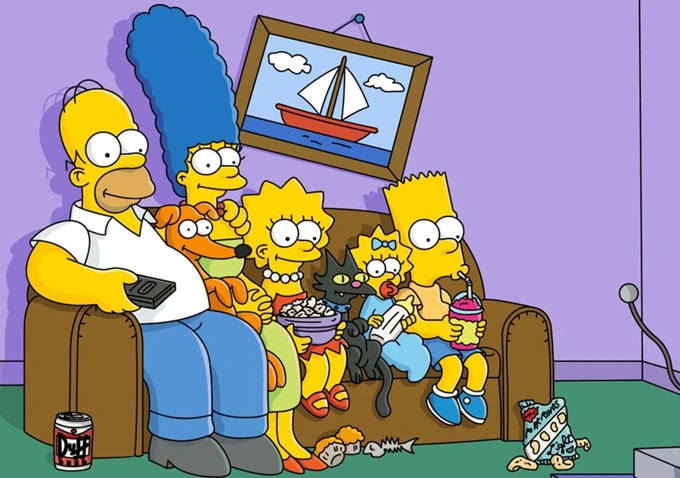

Задача - классифицировать персонажей из мультсериала Симпсоны по изображению.

### Установка зависимостей

Установим модуль torchvision, который включает в себя большинство распространенных датасетов и архитектур нейросетей из CV.

In [1]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install wheel==0.34.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl  torchvision
import torch

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Библиотека PIL - основной инструмент для обработки изображений.

In [5]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.


5.3.0


Эта команда подключает к ноутбуку наш диск гугл-драйв.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Выясняем, как называется наш корневой каталог.

In [7]:
!ls /content/gdrive/

MyDrive  Shareddrives


Можем убедиться, что ранее загруженный архив виден.

In [8]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 18 17:35 /content/gdrive/MyDrive/journey-springfield.zip


Распаковываем архив.

In [9]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [10]:
!ls train
!ls testset

simpsons_dataset
testset


Сохраним нужные нам пути.

In [11]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

Загрузим train и test данные и сверимся с нужной длиной.

In [12]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(f'Size of train and val parts is {len(train_val_files)}') #=> 20933
print(f'Size of test part is {len(test_files)}') #=> 991

Size of train and val parts is 20933
Size of test part is 991


Проверим доступ к GPU.

In [13]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 23 09:37:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 991 картинка, для которых нам будет необходимо предсказать класс.

Сделаем нужные импорты.

In [14]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [15]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

# Предобработка данных и первичный анализ

Для удобной работы с датасетом Симпсонов стоит создать класс-оболочку SimpsonsDataset.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet.


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

Помимо вышеопределенных трансформеров я решил применять различные аугментации. RandomHorizontalFlip c 50-ти процентной вероятностью отзеркаливает изображение, а RandomRotation вращает входное изображение в заданном диапазоне. Нужно это, во-первых, для того, чтобы "искуственно" увеличить набор данных для обучения. Второе преимущество подхода с аугментациями выяснится позднее.

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation([-20, 20]),
                transforms.Lambda(lambda x: np.array(np.array(x) / 255, dtype='float32')),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Lambda(lambda x: np.array(np.array(x) / 255, dtype='float32')),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image     

Определим функцию для прорисовки изображений.

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделим выборку на test и valid части в соотношении 3:1.

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

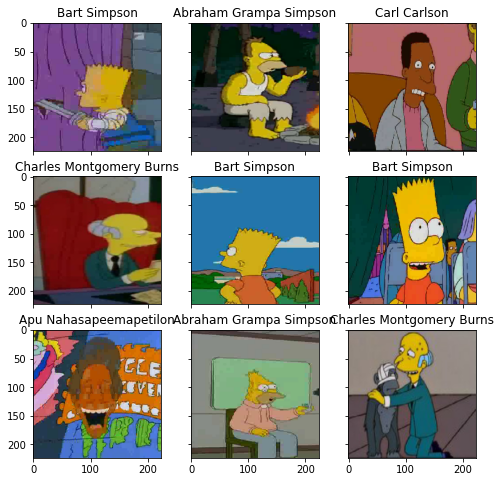

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Определим количество уникальных классов в датасете.

In [22]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


# Distribution

Изобразим на графике распределение классов по их численности.

In [23]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

def simpson_disrt(train_val_labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(train_val_labels)
    new_labels = label_encoder.transform(train_val_labels)

    series = pd.Series(new_labels).value_counts()
    plt.figure(figsize=(12, 8))
    plt.bar(series.index, series, color='red', width=0.3)
    plt.title("Simpsons distribution")
    plt.show()

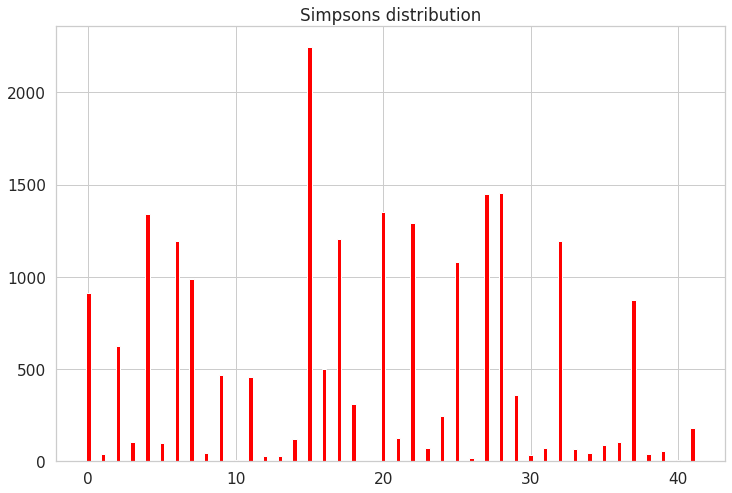

In [24]:
simpson_disrt(train_val_labels)

Из графика видно, что имеется существенный дисбаланс между классами. Для борьбы с этим продублируем картинки малочисленных классов. И вот тут выясняется еще один profit использования множественных аугментаций - оно позволяет избежать переобучения на одинаковых картинках.

Исходный размер обучающего датасета

In [64]:
len(train_files)

15699

In [26]:
def little_classes(labels):
    s = pd.Series(labels).value_counts()

    return dict(s[s < 300])

In [27]:
train_labels = [path.parent.name for path in train_files]

Посмотрим на самые малочисленные классы

In [28]:
classes = little_classes(train_labels)

classes

{'nelson_muntz': 269,
 'lenny_leonard': 233,
 'mayor_quimby': 185,
 'waylon_smithers': 136,
 'maggie_simpson': 96,
 'groundskeeper_willie': 91,
 'barney_gumble': 80,
 'selma_bouvier': 77,
 'carl_carlson': 74,
 'ralph_wiggum': 67,
 'patty_bouvier': 54,
 'martin_prince': 53,
 'professor_john_frink': 49,
 'snake_jailbird': 41,
 'cletus_spuckler': 35,
 'rainier_wolfcastle': 34,
 'agnes_skinner': 32,
 'sideshow_mel': 30,
 'otto_mann': 24,
 'fat_tony': 20,
 'gil': 20,
 'miss_hoover': 13,
 'troy_mcclure': 6,
 'disco_stu': 6,
 'lionel_hutz': 2}

Для некоего 'lionel_hutz' в обучающей части датасета всего 2!!!! изображения.

Определим функцию для добавления дубликатов в (обучающий) датасет. Сразу скажу - в комментариях к заданию многие советуют использовать взвешенный семплер в даталоадерах. Мой подход по сути делает то же самое, но по своему - вместо того чтобы выбирать изображения для батча некоторым взвешенным образом я просто дублирую изображения малочисленных классов и заставляю сеть чаще обучаться на них. Аугментации в свою очередь защищают от переобучения.

In [30]:
def add_dublicate(classes, train_files):
    new_files = []
    for key in classes:
        for path in train_files:
            if path.parent.name == key:
                for i in range(300 // classes[key] + 1):
                    new_files.append(path)

    return train_files + new_files

In [31]:
new_train_files = add_dublicate(classes, train_files)

Теперь размер обучающего датасета примерно в полтора раза больше.

In [32]:
len(new_train_files)

24324

In [33]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')

# Pipeline

Функции для обучения мало отличаются от предложенных в baseline. Основные отличия:

1) Добавлен scheduler для лучшей сходимости

2) В процессе обучения моделей стало ясно, что оптимизатор AdamW дает лучший скор, чем Adam. Так что в готовом ноутбуке решил оставить его


In [35]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [36]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [37]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [38]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# VGG16

Опробовав множество моделей и подходов, остановился на vgg16. В качестве классификатора пробовал как простой линейный слой, так и более изощренные вещи. Стало понятно, что простой линейный классификатор не может дать нужный мне скор, а использование трехслойной fc-сетки с активациями быстро ведет к переобучению. Поэтому было принято решение (суперское) использовать дропауты. Они то и стали основной силой моей модели.

Попробовав подход с features extraction (то есть заморозив веса vgg16) качество улучшилось, но стало ясно, что можно сделать лучше - все таки задачи imagenet и классификации симпсонов довольно разные + достаточное количество данных позволяют fine-tune-ить. И вот когда я разморозил несколько верхних слоев сверток понеслось - качество начало быстро расти. По итогу решил полностью обучиться под свою задачу со всеми рамороженными слоями, но стартовые веса сетки оставил нетронутыми (сходимость на них была в разы лучше).

Но к большому сожалению colab никак не хотел заканчивать обучения и постоянно отрубался. На 4 раз плюнул на это и оставил модель несколько недообученной (13 эпох из 20), но предсказания все равно получились хорошими.

In [52]:
model_vgg_last = models.vgg16(pretrained=True)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg_last.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, n_classes),
)
# Использовать ли GPU
if train_on_gpu:
    model_vgg_last = model_vgg_last.to(DEVICE)

In [53]:
history = train(train_dataset, val_dataset, model=model_vgg_last, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.3230151191018087


epoch:   5%|▌         | 1/20 [06:52<2:10:29, 412.09s/it]


Epoch 001 train_loss: 1.3230     val_loss 0.3138 train_acc 0.6553 val_acc 0.9217
loss 0.18562361248765039


epoch:  10%|█         | 2/20 [13:49<2:04:34, 415.26s/it]


Epoch 002 train_loss: 0.1856     val_loss 0.2726 train_acc 0.9527 val_acc 0.9316
loss 0.09798138738389157


epoch:  15%|█▌        | 3/20 [20:49<1:58:13, 417.25s/it]


Epoch 003 train_loss: 0.0980     val_loss 0.2281 train_acc 0.9743 val_acc 0.9436
loss 0.08801275026437987


epoch:  20%|██        | 4/20 [27:42<1:50:53, 415.84s/it]


Epoch 004 train_loss: 0.0880     val_loss 0.2542 train_acc 0.9757 val_acc 0.9461
loss 0.07081377942674526


epoch:  25%|██▌       | 5/20 [34:41<1:44:11, 416.75s/it]


Epoch 005 train_loss: 0.0708     val_loss 0.2839 train_acc 0.9813 val_acc 0.9461
loss 0.05182808121443126


epoch:  30%|███       | 6/20 [41:41<1:37:29, 417.81s/it]


Epoch 006 train_loss: 0.0518     val_loss 0.2469 train_acc 0.9855 val_acc 0.9482
loss 0.045192770303996294


epoch:  35%|███▌      | 7/20 [48:40<1:30:37, 418.31s/it]


Epoch 007 train_loss: 0.0452     val_loss 0.2592 train_acc 0.9873 val_acc 0.9492
loss 0.01134085321217112


epoch:  40%|████      | 8/20 [55:35<1:23:26, 417.23s/it]


Epoch 008 train_loss: 0.0113     val_loss 0.1878 train_acc 0.9975 val_acc 0.9654
loss 0.004578880804642826


epoch:  45%|████▌     | 9/20 [1:02:32<1:16:27, 417.05s/it]


Epoch 009 train_loss: 0.0046     val_loss 0.1915 train_acc 0.9988 val_acc 0.9690
loss 0.005031105704400303


epoch:  50%|█████     | 10/20 [1:09:27<1:09:26, 416.63s/it]


Epoch 010 train_loss: 0.0050     val_loss 0.1938 train_acc 0.9989 val_acc 0.9683
loss 0.0017389326090013757


epoch:  55%|█████▌    | 11/20 [1:16:21<1:02:20, 415.64s/it]


Epoch 011 train_loss: 0.0017     val_loss 0.1992 train_acc 0.9995 val_acc 0.9687
loss 0.0015255957459059898


epoch:  60%|██████    | 12/20 [1:23:22<55:38, 417.34s/it]


Epoch 012 train_loss: 0.0015     val_loss 0.2124 train_acc 0.9997 val_acc 0.9683
loss 0.0019207370759056028


epoch:  65%|██████▌   | 13/20 [1:30:21<48:44, 417.85s/it]


Epoch 013 train_loss: 0.0019     val_loss 0.2238 train_acc 0.9994 val_acc 0.9673


epoch:  65%|██████▌   | 13/20 [1:31:21<49:11, 421.65s/it]


KeyboardInterrupt: ignored

In [65]:
torch.save(model_vgg_last.state_dict(), 'Simpsons_best.pth')

# F1-SCORE

In [56]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [57]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_vgg_last, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_vgg_last, imgs)

In [58]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [59]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [60]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

1.0

# Submit на Kaggle

In [61]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_vgg_last, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [62]:
my_submit = pd.read_csv("sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})

my_submit['Expected'] = preds
my_submit['Id'] = test_filenames

In [63]:
my_submit.to_csv('Simpsons_best.csv', index=False)

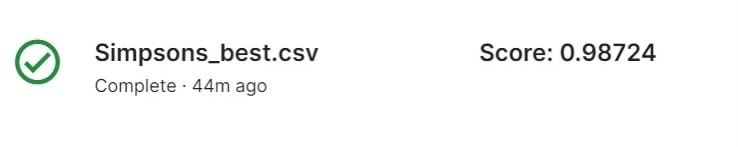

# P.S.

In [66]:
def character(files, name):
    lst = []
    for path in files:
        if path.parent.name == name:
            lst.append(path)

    return lst

In [67]:
homer_dataset = SimpsonsDataset(character(val_files, 'homer_simpson'), mode='val')

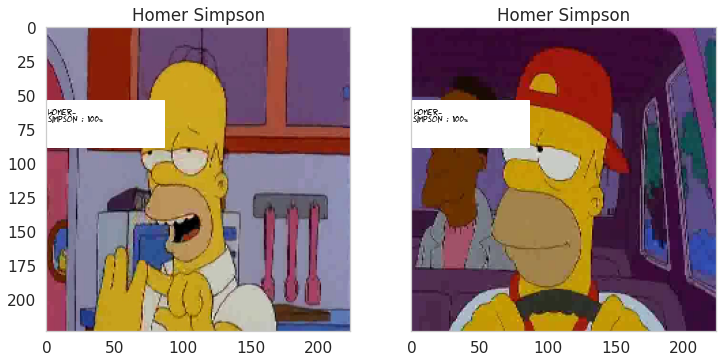

In [68]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 12), \
                        sharey=True, sharex=True)

i = 4
for fig_x in ax.flatten():
    random_characters =  i                    
    i += 1
    im_val, label = homer_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                homer_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_vgg_last, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')